# REINFORCE with Baseline
### Solving `Cartpole_v1` Problem
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 8th, 2024

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

<center><img src="Reinf_base_dong.png" alt="VPG algotirhm, Ref: Dong" width=550/></center>

In [3]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, learning_rate=1e-3):
        self.gamma = 0.99
        self.policy_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.value_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
        # Policy Network
        inputs = Input(shape=(state_dim,))
        x = Dense(8, activation='relu')(inputs)
        # x = Dense(16, activation='relu')(x)
        policy_output = Dense(action_dim, activation='softmax')(x)
        self.policy_network = keras.Model(inputs=inputs, outputs=policy_output)
        
        # History tracking
        self.policy_loss_history = []

    def get_action(self, state):
        state = np.array([state])
        probs = self.policy_network(state).numpy().flatten()
        return np.random.choice(len(probs), p=probs)
    
    def compute_returns(self, rewards):
        returns = np.zeros_like(rewards, dtype=np.float32)
        running_sum = 0
        for t in reversed(range(len(rewards))):
            running_sum = running_sum * self.gamma + rewards[t]
            returns[t] = running_sum
        # return returns
        return (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    
    def update_policy(self, states, actions, rerutns):
        states = np.array(states)
        actions = np.array(actions)
        rerutns = np.array(rerutns)
        
        with tf.GradientTape() as tape:
            logits = self.policy_network(states, training=True)
            indices = tf.range(0, tf.shape(logits)[0]) * tf.shape(logits)[1] + actions
            action_probs = tf.gather(tf.reshape(logits, [-1]), indices)
            policy_loss = -tf.reduce_mean(tf.math.log(action_probs) * rerutns)
            
        policy_grads = tape.gradient(policy_loss, self.policy_network.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy_network.trainable_variables))
        
        self.policy_loss_history.append(policy_loss.numpy())
        return policy_loss.numpy()

In [4]:
class REINFORCEWithBaseline(REINFORCE):
    def __init__(self, state_dim, action_dim, learning_rate=1e-3):
        super().__init__(state_dim, action_dim, learning_rate)
        
        # Value network (baseline)
        inputs = Input(shape=(state_dim,))
        x = Dense(8, activation='relu')(inputs)
        # x = Dense(16, activation='relu')(x)
        value_output = Dense(1, activation=None)(x)
        self.value_network = keras.Model(inputs=inputs, outputs=value_output)
        
        # History tracking
        self.value_loss_history = []
    
    def update_policy(self, states, actions, advantages):
        states = np.array(states)
        actions = np.array(actions)
        advantages = np.array(advantages)
        
        with tf.GradientTape() as tape:
            logits = self.policy_network(states, training=True)
            indices = tf.range(0, tf.shape(logits)[0]) * tf.shape(logits)[1] + actions
            action_probs = tf.gather(tf.reshape(logits, [-1]), indices)
            policy_loss = -tf.reduce_mean(tf.math.log(action_probs) * advantages)
            
        policy_grads = tape.gradient(policy_loss, self.policy_network.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy_network.trainable_variables))
        
        self.policy_loss_history.append(policy_loss.numpy())
        return policy_loss.numpy()
    
    def update_value(self, states, returns):
        states = np.array(states)
        returns = np.array(returns)
        
        with tf.GradientTape() as tape:
            values = self.value_network(states, training=True)
            values = tf.squeeze(values)
            value_loss = tf.reduce_mean(tf.square(returns - values))
            
        value_grads = tape.gradient(value_loss, self.value_network.trainable_variables)
        self.value_optimizer.apply_gradients(zip(value_grads, self.value_network.trainable_variables))
        
        self.value_loss_history.append(value_loss.numpy())
        return value_loss.numpy()

In [5]:
def train(agent, num_episodes=1000, render=False):
    max_steps = 200
    episode_rewards = []
    moving_average = []
    window_size = 100
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        states, actions, rewards = [], [], []
        episode_reward = 0
        done = False
        steps = 0
        
        # Collect trajectory
        while not done and steps < max_steps:
            if render and episode % 100 == 0:
                env.render()
                
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            episode_reward += reward
            steps += 1
            state = next_state
        
        episode_rewards.append(episode_reward)
        if len(episode_rewards) >= window_size:
            moving_avg = np.mean(episode_rewards[-window_size:])
            moving_average.append(moving_avg)
        
        # Process returns and advantages
        states = np.array(states)
        returns = agent.compute_returns(rewards)
        
        values = agent.value_network(states).numpy().flatten()
        advantages = returns - values
        
        # Update networks
        policy_loss = agent.update_policy(states, actions, advantages)
        value_loss = agent.update_value(states, returns)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1:4d} | "
                  f"Average Reward (last 100): {avg_reward:.2f} | "
                  f"Policy Loss: {policy_loss:.4f} | "
                  f"Value Loss: {value_loss:.4f}")
    
    return episode_rewards, moving_average, agent.policy_loss_history, agent.value_loss_history

In [6]:
%%time

agent = REINFORCEWithBaseline(state_dim, action_dim)
rewards, moving_avg, policy_losses, value_losses = train(agent, num_episodes=2000)

Episode  100 | Average Reward (last 100): 17.09 | Policy Loss: 0.1388 | Value Loss: 0.6571
Episode  200 | Average Reward (last 100): 17.90 | Policy Loss: 0.2122 | Value Loss: 0.4998
Episode  300 | Average Reward (last 100): 18.58 | Policy Loss: 0.0445 | Value Loss: 0.8213
Episode  400 | Average Reward (last 100): 19.26 | Policy Loss: 0.2345 | Value Loss: 0.4979
Episode  500 | Average Reward (last 100): 22.86 | Policy Loss: 0.1042 | Value Loss: 0.3710
Episode  600 | Average Reward (last 100): 33.61 | Policy Loss: -0.2115 | Value Loss: 0.9234
Episode  700 | Average Reward (last 100): 43.06 | Policy Loss: -0.1352 | Value Loss: 0.7411
Episode  800 | Average Reward (last 100): 65.80 | Policy Loss: -0.1070 | Value Loss: 1.0442
Episode  900 | Average Reward (last 100): 90.68 | Policy Loss: -0.1733 | Value Loss: 0.8543
Episode 1000 | Average Reward (last 100): 130.58 | Policy Loss: -0.0688 | Value Loss: 0.5790
Episode 1100 | Average Reward (last 100): 146.82 | Policy Loss: 0.1228 | Value Loss:

> **TODO:** Modify these parameters:
> - Learning Rates (Policy and value)
> - gamma (discount factor)
> - Network architectures

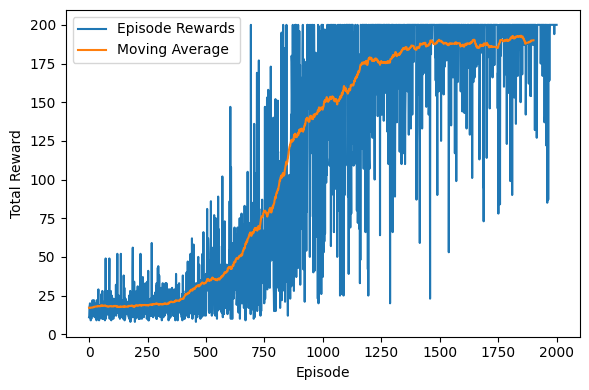

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(rewards, label='Episode Rewards')
plt.plot(range(len(moving_avg)), moving_avg, label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.tight_layout()
plt.legend()
plt.show()

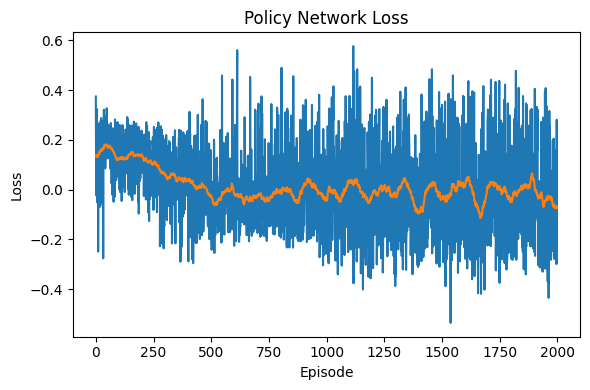

In [8]:
from scipy.ndimage import uniform_filter
policy_losses_avg = uniform_filter(policy_losses, size=50)

plt.figure(figsize=(6, 4))
plt.plot(policy_losses)
plt.plot(policy_losses_avg)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Policy Network Loss')
plt.tight_layout()
plt.show()

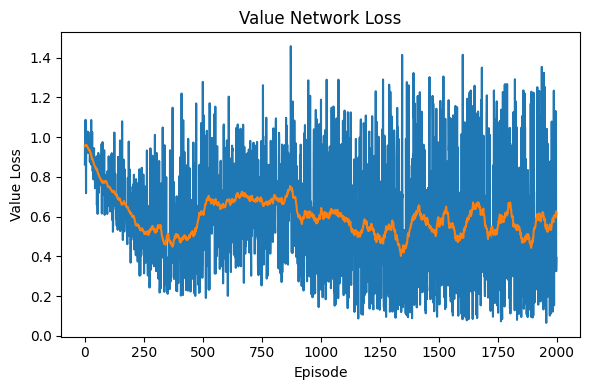

In [9]:
value_losses_avg = uniform_filter(value_losses, size=50)

plt.figure(figsize=(6, 4))
plt.plot(value_losses)
plt.plot(value_losses_avg)
plt.xlabel('Episode')
plt.ylabel('Value Loss')
plt.title('Value Network Loss')
plt.tight_layout()
plt.show()

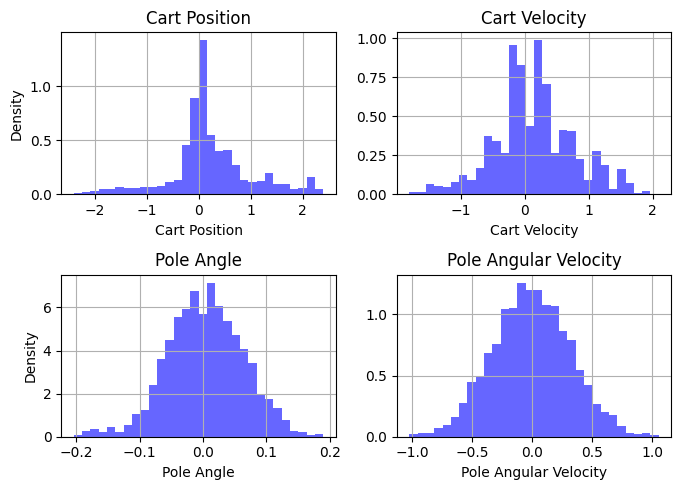

In [10]:
# TODO